In [107]:
import os
import random
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



from MnistNet import MnistNet

In [108]:
NUM_EPOCHS = 6
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 28
NUM_CLASSES = 10
DEVICE_IDS = [0, 1, 2, 3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [109]:
# print the seed value
# seed = torch.initial_seed()
# print('Used seed : {}'.format(seed))

In [110]:
mnistnet = MnistNet(num_classes=NUM_CLASSES).to(device)
mnistnet = torch.nn.parallel.DataParallel(mnistnet, device_ids=DEVICE_IDS)
print(mnistnet)
print('MnistNet created')

DataParallel(
  (module): MnistNet(
    (net): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU()
      (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=256, out_features=4096, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace

In [111]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [112]:
print(X.shape)
X = X.reshape(X.shape[0], 1, 28, 28)
print(X.shape)

(70000, 784)
(70000, 1, 28, 28)


In [113]:
def attack_image(xs, img):
    img = img.reshape(28, 28)
    imgs = []
    for i, x in enumerate(xs):
            y_pos, x_pos, intensity = x
            imgs.append(img.copy())
            imgs[i][y_pos][x_pos] = intensity

    return imgs

In [114]:
with open("attack_pixels.txt", "r") as file:
    attack_pixels_str = file.read().split("\n")[:-1]
attack_pixels = []
for pixel_str in attack_pixels_str:
    attack_pixels.append([int(pixel_str.split('[')[1].split(',')[0]),
                         int(pixel_str.split(',')[1].split(']')[0])])
print(len(attack_pixels))

18


In [115]:
X_attacked = []
y_attacked = []
for k, img in tqdm(enumerate(X)):
    img = img.reshape(28, 28)
    vec = []
    for pixel in attack_pixels:
        vec.append([pixel[0], pixel[1], 255])
    #print(vec)

    attacked_imgs = attack_image(vec, img)
    X_attacked+=attacked_imgs
    y_attacked += [y[k]]*len(attacked_imgs)

X_attacked = np.array(X_attacked)
y_attacked = np.array(y_attacked)

70000it [00:12, 5671.37it/s]


In [116]:
print(len(X_attacked), len(y_attacked))

1260000 1260000


In [117]:
X_attacked = X_attacked.reshape(X_attacked.shape[0], 1, 28, 28)

In [118]:
TRAIN_PERCENTAGE = 0.8
TRAIN_NUMBER = int(len(X_attacked) * TRAIN_PERCENTAGE)

In [119]:
X_train, X_test, y_train, y_test = X_attacked[:TRAIN_NUMBER], X_attacked[TRAIN_NUMBER:], y_attacked[:TRAIN_NUMBER], y_attacked[TRAIN_NUMBER:]
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),
                              torch.from_numpy(y_train).long())
train_loader = DataLoader(train_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

test_dataset = TensorDataset(torch.from_numpy(X_test).float(),
                             torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=8,
                          drop_last=True,
                          batch_size=BATCH_SIZE)

In [120]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

In [121]:
def evaluate_model(nn_model):
    nn_model.eval()
    with torch.no_grad():
        correct_out = 0
        total_out = 0
        for pics, lbls in test_loader:
            out = nn_model(pics)
            pred = torch.argmax(out, dim=1)
            total_out += lbls.shape[0]
            correct_out += (pred == lbls).sum().item()

    loss_current = criterion(out, lbls)
    return correct_out / total_out, loss_current

In [122]:
# create optimizer
# the one that WORKS
optimizer = optim.Adam(params=mnistnet.parameters(), lr=0.0001)
### BELOW is the setting proposed by the original paper - which doesn't train....
# optimizer = optim.SGD(
#     params=alexnet.parameters(),
#     lr=LR_INIT,
#     momentum=MOMENTUM,
#     weight_decay=LR_DECAY)
print('Optimizer created')

Optimizer created


In [123]:
# multiply LR by 1 / 10 after every 30 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print('LR Scheduler created')

accuracy_test_stat = []
accuracy_train_stat = []
loss_test_stat = []
loss_train_stat = []

# start training!!
print('Starting training...')
total_steps = 1
for epoch in range(NUM_EPOCHS):
    epoch_tr_accuracy = 0
    epoch_tr_loss = 0

    lr_scheduler.step()
    for imgs, classes in train_loader:
        imgs, classes = imgs.to(device), classes.to(device)

        # calculate the loss
        output = mnistnet(imgs)
        loss = F.cross_entropy(output, classes)

        # update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log the information and add to tensorboard
        if total_steps % 200 == 0:
            with torch.no_grad():
                predictions = torch.argmax(output, dim=1)
                accuracy = (predictions == classes).sum() / len(predictions)

                epoch_tr_accuracy = accuracy.item()
                epoch_tr_loss = loss.item()

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                      .format(epoch + 1, total_steps, loss.item(), epoch_tr_accuracy))


        if total_steps % 400 == 0:
            a, l = evaluate_model(mnistnet)
            accuracy_train_stat.append(epoch_tr_accuracy)
            accuracy_test_stat.append(a)

            loss_train_stat.append(epoch_tr_loss)
            loss_test_stat.append(l)
        total_steps += 1



    # print(accuracy_test_stat, accuracy_train_stat, loss_test_stat, loss_train_stat)



LR Scheduler created
Starting training...


/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1 	Step: 200 	Loss: 0.2544 	Acc: 0.921875
Epoch: 1 	Step: 400 	Loss: 0.1398 	Acc: 0.953125
Epoch: 1 	Step: 600 	Loss: 0.0999 	Acc: 0.9765625
Epoch: 1 	Step: 800 	Loss: 0.0655 	Acc: 0.9765625
Epoch: 1 	Step: 1000 	Loss: 0.0981 	Acc: 0.96875
Epoch: 1 	Step: 1200 	Loss: 0.0551 	Acc: 0.9765625
Epoch: 1 	Step: 1400 	Loss: 0.0381 	Acc: 0.9921875
Epoch: 1 	Step: 1600 	Loss: 0.0125 	Acc: 1.0
Epoch: 1 	Step: 1800 	Loss: 0.0407 	Acc: 0.984375
Epoch: 1 	Step: 2000 	Loss: 0.0914 	Acc: 0.984375
Epoch: 1 	Step: 2200 	Loss: 0.0171 	Acc: 0.9921875
Epoch: 1 	Step: 2400 	Loss: 0.0024 	Acc: 1.0
Epoch: 1 	Step: 2600 	Loss: 0.0773 	Acc: 0.9765625
Epoch: 1 	Step: 2800 	Loss: 0.0094 	Acc: 1.0
Epoch: 1 	Step: 3000 	Loss: 0.0209 	Acc: 0.984375
Epoch: 1 	Step: 3200 	Loss: 0.0471 	Acc: 0.9765625
Epoch: 1 	Step: 3400 	Loss: 0.0143 	Acc: 0.9921875
Epoch: 1 	Step: 3600 	Loss: 0.0453 	Acc: 0.984375
Epoch: 1 	Step: 3800 	Loss: 0.0113 	Acc: 0.9921875
Epoch: 1 	Step: 4000 	Loss: 0.0755 	Acc: 0.984375
Epoch: 1 	S

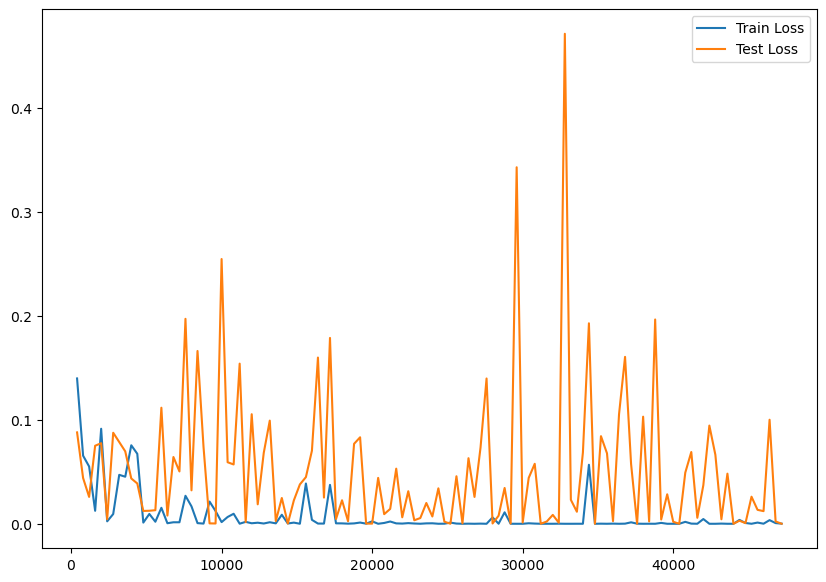

In [135]:
epochs = np.multiply(range(1, len(loss_train_stat)+1), 400)
plt.figure(figsize=(10, 7))
plt.plot(epochs, loss_train_stat)
plt.plot(epochs, loss_test_stat)
plt.legend(["Train Loss", "Test Loss"])
plt.show()

[0.960230881605691, 0.9795239456300813, 0.9807783917682927, 0.9809054242886179, 0.9834143165650406, 0.986939469004065, 0.9814135543699187, 0.9811634590955285, 0.9865424923780488, 0.9861693343495935, 0.9852761369410569, 0.9873205665650406, 0.987769150152439, 0.9866060086382114, 0.988598831300813, 0.9879438198678862, 0.989134749745935, 0.9890434451219512, 0.9872451410060976, 0.9887735010162602, 0.9896270007621951, 0.9870625317581301, 0.9851371951219512, 0.9888489265752033, 0.9867052527947154, 0.9888687754065041, 0.9902661331300813, 0.9898453379065041, 0.9916396722560976, 0.989428512449187, 0.9882693407012195, 0.9907385353150406, 0.9874396595528455, 0.9896389100609756, 0.9886702870934959, 0.9893372078252033, 0.9901351308434959, 0.9890712334857723, 0.9893054496951219, 0.9892538427337398, 0.991234756097561, 0.9896825774898373, 0.9895912728658537, 0.989329268292683, 0.9903336191565041, 0.9917349466463414, 0.9907782329776422, 0.9905956237296748, 0.9905718051321138, 0.9901510099085366, 0.98838

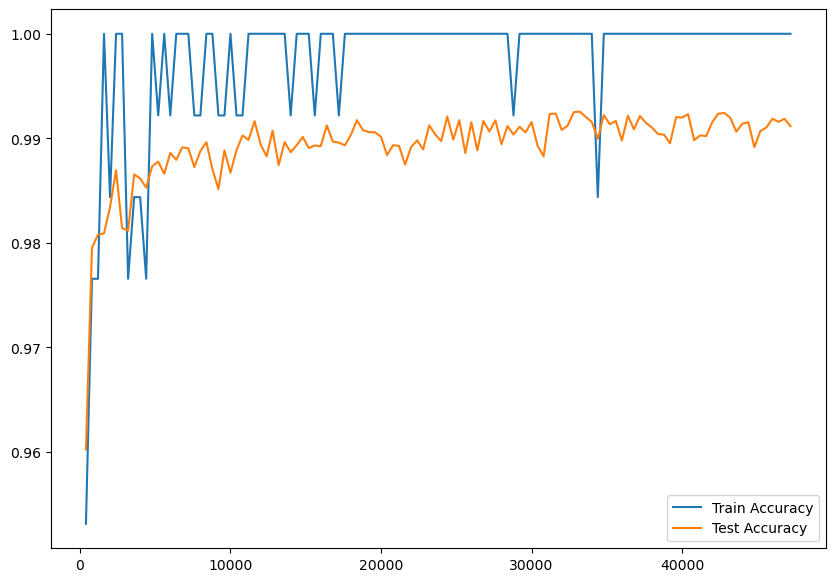

In [136]:
epochs = np.multiply(range(1, len(loss_train_stat)+1), 400)
plt.figure(figsize=(10, 7))
print(accuracy_test_stat)
plt.plot(epochs, accuracy_train_stat)
plt.plot(epochs, accuracy_test_stat)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

In [126]:
import cv2
import numpy as np

data = []
classes = [2, 3, 6, 8, 9, 1, 0, 4, 7, 5]
for i in range(10):
    img = cv2.imread("../my_dataset/"+str(i+1)+".png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sharp_filter = np.array([[-1, 0, -1],
                             [ 0, 7,  0],
                             [-1, 0, -1]])
    img = cv2.filter2D(img, ddepth=-1, kernel=sharp_filter)

    img = cv2.bitwise_not(img)
    img = img.astype('float32')
    data.append(img)

data = np.reshape(data,(len(data), 1, 28, 28))
# data = np.array(data)
classes = np.array(classes)

print(data.shape)

(10, 1, 28, 28)


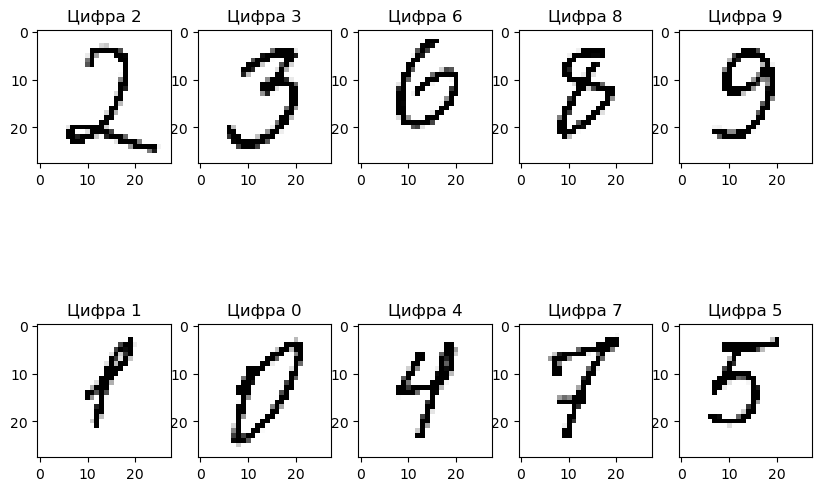

In [127]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % classes[i])

In [128]:
experiment_dataset = TensorDataset(torch.from_numpy(data).float(),
                                   torch.from_numpy(classes).long())
experiment_loader = DataLoader(experiment_dataset,
                          shuffle=False,
                          # pin_memory=True,
                          # num_workers=8,
                          # drop_last=True,

                          batch_size=BATCH_SIZE)

mnistnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in experiment_loader:
        outputs = mnistnet(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    print("Test accuracy:",
        100 * correct / total, "%")


Test accuracy: 100.0 %


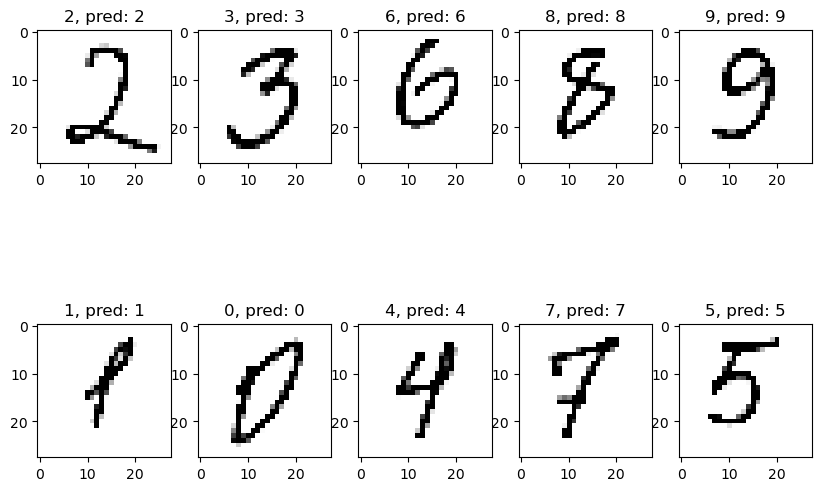

In [129]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("%d, pred: %d" % (classes[i], predicted[i]))

In [130]:
torch.save(mnistnet, 'mnistnet_pixel1.pkl')

In [131]:
mdl = torch.load('mnistnet_pixel1.pkl')
mdl

DataParallel(
  (module): MnistNet(
    (net): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU()
      (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): ReLU()
      (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=256, out_features=4096, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace

In [132]:
for images, labels in test_loader:
        outputs = mdl(images)
        predicted = torch.argmax(outputs, dim=1)

        print((predicted == labels).sum().item() / len(labels))

0.9921875
0.9921875
1.0
0.9921875
1.0
0.9921875
1.0
0.9921875
0.984375
0.9921875
1.0
1.0
0.984375
0.9921875
0.9921875
0.9921875
0.984375
0.9765625
1.0
1.0
0.984375
0.9921875
0.984375
0.9921875
1.0
0.9921875
0.9921875
0.984375
0.96875
0.96875
1.0
1.0
0.984375
1.0
1.0
0.9921875
0.984375
0.984375
1.0
0.9921875
0.9921875
1.0
0.9921875
0.9765625
1.0
0.96875
0.984375
1.0
1.0
0.9921875
1.0
1.0
1.0
0.9765625
0.984375
0.984375
1.0
0.9921875
0.9921875
0.984375
0.9921875
0.9921875
0.9765625
1.0
0.9921875
1.0
0.984375
1.0
0.984375
0.9765625
0.984375
0.9921875
1.0
1.0
0.9921875
0.9921875
0.984375
0.984375
0.984375
0.984375
0.984375
1.0
0.9921875
1.0
0.9921875
0.9921875
0.9921875
0.9921875
0.9921875
0.984375
1.0
0.984375
0.984375
0.9921875
1.0
1.0
0.9921875
0.9921875
0.9921875
0.9921875
0.984375
0.984375
0.9921875
0.984375
0.9921875
1.0
0.9921875
1.0
1.0
1.0
1.0
0.984375
1.0
1.0
0.984375
0.9921875
0.984375
1.0
1.0
1.0
1.0
1.0
1.0
0.984375
1.0
0.9921875
0.9921875
1.0
0.9921875
1.0
0.9921875
0.9921875